<a href="https://colab.research.google.com/github/imabari/rakuten_tools/blob/main/%E6%A5%BD%E5%A4%A9%E3%83%A2%E3%83%90%E3%82%A4%E3%83%AB%E9%95%B7%E6%9C%9F%E3%83%A1%E3%83%B3%E3%83%86%E3%83%8A%E3%83%B3%E3%82%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget "https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId=A002005212015&code=20&coordSys=1&format=shape&downloadType=5&datum=2000" -O nagano.zip

--2022-06-20 08:42:59--  https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId=A002005212015&code=20&coordSys=1&format=shape&downloadType=5&datum=2000
Resolving www.e-stat.go.jp (www.e-stat.go.jp)... 111.108.189.107, 2001:268:83a:ff::9
Connecting to www.e-stat.go.jp (www.e-stat.go.jp)|111.108.189.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘nagano.zip’

nagano.zip              [   <=>              ]   7.02M   872KB/s    in 9.1s    

2022-06-20 08:43:10 (788 KB/s) - ‘nagano.zip’ saved [7357141]



In [2]:
!pip install geopandas
!pip install rtree
!pip install pygeos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 9.2 MB/s 
     |████████████████████████████████| 16.7 MB 2.6 MB/s 
     |████████████████████████████████| 6.3 MB 7.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 14.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 25.8 MB/s 


In [3]:
!pip install jageocoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.2 MB 21.1 MB/s 
  Created wheel for jageocoder: filename=jageocoder-1.3.1-py3-none-any.whl size=54864 sha256=59453e6e1e086e08b8d03133d331e33cedd335bbbdd822bb8e48c93cd540e503
  Stored in directory: /root/.cache/pip/wheels/cc/8e/a4/3dc3ea0491e413a536af5a8922fb1b9aa93f1b6a7db7f21a56
  Created wheel for jaconv: filename=jaconv-0.3-py3-none-any.whl size=15564 sha256=21e5ba5534846f837cf15211f11d3a40288a677e8d7610573fd9214c41010d17
  Stored in directory: /root/.cache/pip/wheels/8f/4f/c2/a2a3b14d0e94f855f4aa8887bf0267bee9ecfb8e62a9ee2d92
Successfully built jageocoder jaconv


In [4]:
!python -m jageocoder install-dictionary

INFO:jageocoder.module:202:Downloading zipped dictionary from https://www.info-proto.com/static/jusho-20220519.zip
INFO:jageocoder.module:204:.. download complete.
INFO:jageocoder.module:211:Extracting /tmp/tmpxq9yu6of to /usr/jageocoder/db/
INFO:jageocoder.module:217:Please check /usr/jageocoder/db/README.txt for terms and conditions of use.
INFO:jageocoder.module:232:Creating TRIE index at /usr/jageocoder/db/address.trie
[SQL: DROP INDEX ix_trienode_trie_id]
(Background on this error at: https://sqlalche.me/e/14/e3q8)
INFO:jageocoder.module:235:Installation completed.


In [5]:
import jageocoder
import pandas as pd
import geopandas as gpd

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [6]:
# 解像度
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 200

In [7]:
jageocoder.init()

In [8]:
df0 = pd.read_json("https://network.mobile.rakuten.co.jp/assets/json/maintenance-short.json")
df0

,都道府県,短期メンテナンス工事,作業開始時間,作業終了時間,お客様への影響,対象地域
0,北海道,更新日,2022年6月24日 1:00,2022年6月24日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,北海道えりも町字大和の一部地域
1,北海道,2022/6/20,2022年6月24日 1:00,2022年6月24日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,北海道えりも町字本町の一部地域
2,北海道,,2022年6月15日 1:00,2022年6月15日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,北海道三笠市唐松町の一部地域
3,北海道,,2022年6月24日 1:00,2022年6月24日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,北海道三笠市多賀町の一部地域
4,北海道,,2022年6月15日 1:00,2022年6月15日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,北海道三笠市岡山の一部地域
...,...,...,...,...,...,...
1273,長野,,2022年6月23日 1:00,2022年6月23日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県高山村大字高井字二反田の一部地域
1274,長野,,2022年6月21日 1:00,2022年6月21日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県高森町下市田の一部地域
1275,長野,,2022年6月16日 1:00,2022年6月16日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県高森町山吹の一部地域
1276,長野,,2022年6月21日 1:00,2022年6月21日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県高森町山吹の一部地域


In [9]:
df1 = df0[df0["都道府県"] == "長野"].copy().reset_index(drop=True)

In [10]:
df1["住所"] = df1["対象地域"].str.replace("の一部地域", "")

In [11]:
df1

,都道府県,短期メンテナンス工事,作業開始時間,作業終了時間,お客様への影響,対象地域,住所
0,長野,,2022年6月21日 1:00,2022年6月21日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県上松町大字上松の一部地域,長野県上松町大字上松
1,長野,,2022年6月21日 1:00,2022年6月21日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県上松町大字小川の一部地域,長野県上松町大字小川
2,長野,,2022年6月21日 1:00,2022年6月21日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県上松町大字荻原の一部地域,長野県上松町大字荻原
3,長野,,2022年6月21日 1:00,2022年6月21日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県上松町緑町の一部地域,長野県上松町緑町
4,長野,,2022年6月16日 1:00,2022年6月16日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県上田市上丸子字棒田の一部地域,長野県上田市上丸子字棒田
...,...,...,...,...,...,...,...
618,長野,,2022年6月23日 1:00,2022年6月23日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県高山村大字高井字二反田の一部地域,長野県高山村大字高井字二反田
619,長野,,2022年6月21日 1:00,2022年6月21日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県高森町下市田の一部地域,長野県高森町下市田
620,長野,,2022年6月16日 1:00,2022年6月16日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県高森町山吹の一部地域,長野県高森町山吹
621,長野,,2022年6月21日 1:00,2022年6月21日 5:00,作業時間内で30分未満の通信断が発生し、音声通話およびデータ通信が、ご利用いただけない場合が...,長野県高森町山吹の一部地域,長野県高森町山吹


In [12]:
features = []

for s in df1["住所"]:

    results = jageocoder.searchNode(s)
 
    if len(results) > 0:

        node = results[0].node

        features.append(node.as_geojson())

In [13]:
import json

In [14]:
import io

In [15]:
pt_df = gpd.GeoDataFrame().from_features(features, crs="EPSG:4612")
pt_df

,geometry,id,name,level,priority,note,fullname
0,POINT (137.69202 35.80413),19178711,大字上松,5,2,aza_id:0000137/postcode:3995601,"[長野県, 木曽郡, 上松町, 大字上松]"
1,POINT (137.64275 35.76428),19178789,大字小川,5,2,aza_id:0004000/postcode:3995607,"[長野県, 木曽郡, 上松町, 大字小川]"
2,POINT (137.72983 35.75325),19179162,大字荻原,5,2,aza_id:0000105/postcode:3995608,"[長野県, 木曽郡, 上松町, 大字荻原]"
3,POINT (137.69555 35.78189),19179521,緑町,5,2,,"[長野県, 木曽郡, 上松町, 緑町]"
4,POINT (138.27739 36.31917),19190108,上丸子,5,2,aza_id:0017000/postcode:3860404,"[長野県, 上田市, 上丸子]"
...,...,...,...,...,...,...,...
618,POINT (138.36293 36.66421),19133967,大字高井,5,2,aza_id:0002000,"[長野県, 上高井郡, 高山村, 大字高井]"
619,POINT (137.87495 35.54461),19137079,下市田,5,2,aza_id:0005000/postcode:3993103,"[長野県, 下伊那郡, 高森町, 下市田]"
620,POINT (137.88259 35.58361),19139189,山吹,5,2,aza_id:0006000/postcode:3993101,"[長野県, 下伊那郡, 高森町, 山吹]"
621,POINT (137.88259 35.58361),19139189,山吹,5,2,aza_id:0006000/postcode:3993101,"[長野県, 下伊那郡, 高森町, 山吹]"


In [16]:
nagano = gpd.read_file("nagano.zip")

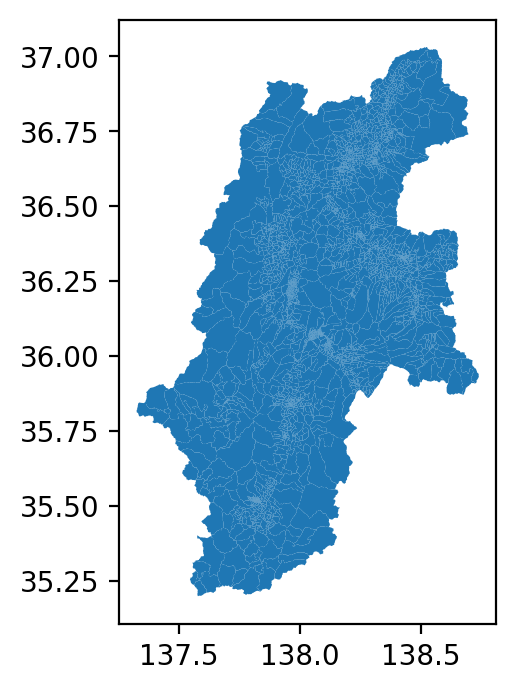

In [17]:
nagano.plot()

In [18]:
# geometryから市町村名を取得
spj = gpd.sjoin(pt_df, nagano).reset_index(drop=True)
spj

,geometry,id,name,level,priority,note,fullname,index_right,KEY_CODE,PREF,...,N_KEN,N_CITY,KIGO_I,MOJI,KBSUM,JINKO,SETAI,X_CODE,Y_CODE,KCODE1
0,POINT (137.69202 35.80413),19178711,大字上松,5,2,aza_id:0000137/postcode:3995601,"[長野県, 木曽郡, 上松町, 大字上松]",3189,204220010,20,...,None,None,None,大字上松,0,0,0,137.68867,35.80136,0010-00
1,POINT (137.64275 35.76428),19178789,大字小川,5,2,aza_id:0004000/postcode:3995607,"[長野県, 木曽郡, 上松町, 大字小川]",3190,204220020,20,...,None,None,None,大字小川,19,1982,752,137.72884,35.78683,0020-00
2,POINT (137.72983 35.75325),19179162,大字荻原,5,2,aza_id:0000105/postcode:3995608,"[長野県, 木曽郡, 上松町, 大字荻原]",3191,204220030,20,...,None,None,None,大字荻原,10,687,238,137.71935,35.74854,0030-00
3,POINT (137.69555 35.78189),19179521,緑町,5,2,,"[長野県, 木曽郡, 上松町, 緑町]",3196,204220080,20,...,None,None,None,緑町,3,254,113,137.69474,35.78010,0080-00
4,POINT (138.27739 36.31917),19190108,上丸子,5,2,aza_id:0017000/postcode:3860404,"[長野県, 上田市, 上丸子]",727,20203070001,20,...,None,None,None,上丸子三反田,21,742,304,138.27788,36.31590,0700-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,POINT (138.36293 36.66421),19133967,大字高井,5,2,aza_id:0002000,"[長野県, 上高井郡, 高山村, 大字高井]",3470,20543001006,20,...,None,None,None,大字高井赤和,2,333,104,138.37145,36.65887,0010-06
619,POINT (137.87495 35.54461),19137079,下市田,5,2,aza_id:0005000/postcode:3993103,"[長野県, 下伊那郡, 高森町, 下市田]",3135,20403006004,20,...,None,None,None,下市田下市田３区,10,946,321,137.87292,35.54309,0060-04
620,POINT (137.88259 35.58361),19139189,山吹,5,2,aza_id:0006000/postcode:3993101,"[長野県, 下伊那郡, 高森町, 山吹]",3145,20403007007,20,...,None,None,None,山吹新田,5,362,120,137.88555,35.58651,0070-07
621,POINT (137.88259 35.58361),19139189,山吹,5,2,aza_id:0006000/postcode:3993101,"[長野県, 下伊那郡, 高森町, 山吹]",3145,20403007007,20,...,None,None,None,山吹新田,5,362,120,137.88555,35.58651,0070-07


In [19]:
df = spj["KEY_CODE"].value_counts().reset_index().rename(columns={"index": "KEY_CODE", "KEY_CODE": "value"})

In [20]:
df

,KEY_CODE,value
0,20321003008,14
1,203500030,8
2,20203073003,6
3,20201064002,6
4,202170311,6
...,...,...
356,20219014003,1
357,20219013004,1
358,202190090,1
359,20219005005,1


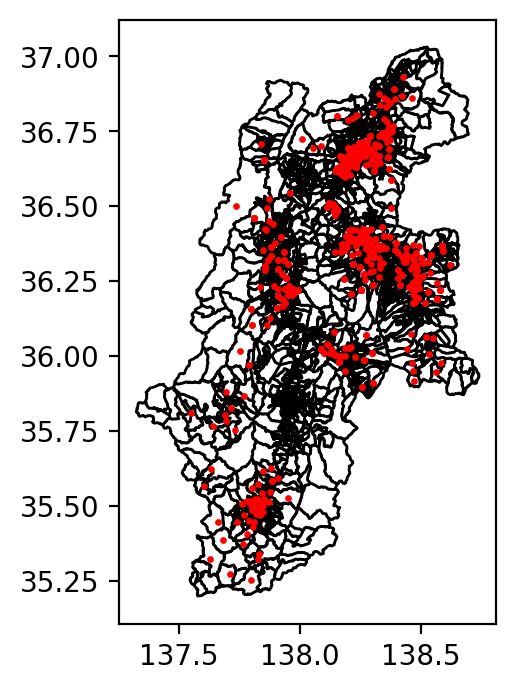

In [21]:
base = nagano.plot(color="white", edgecolor="black")
spj.plot(ax=base, marker="o", color="red", markersize=2)